# CSAP Live Migration Dataset

This notebook reproduces the result in the paper "A Machine Learning Approach to Live Migration Modeling" presented in SoCC'17.

## Import Python Packages

In [159]:
%matplotlib notebook
import statistics
import time
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from matplotlib.ticker import EngFormatter

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline

## Load the Dataset

In [2]:
df = pd.read_csv('dataset/2017.socc.dataset.csv')

# Shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

# Rename column names for readability
df = df.rename(columns={'qemu_tt': 'Total Time', 'qemu_dt': 'Downtime', 'qemu_td': 'Total Data',
                        'performance': 'Performance', 'used_cpu_src': 'SRC.CPU', 'used_mem_src': 'SRC.MEM'})

# Rename the column values to readable strings
df['capability'] = df['capability'].map({0: 'PRE', 1: 'THR', 2: 'DLTC', 3: 'DTC', 4: 'POST'})
df['workload_type'] = df['workload_type'].map({0: 'idle', 1: 'synthetic', 2: 'specweb', 3: 'oltpbench', 4: 'memcached', 5: 'dacapo', 6: 'parsec', 7: 'bzip', 8: 'mplayer'})

df[:10]

capability workload_type      VM_size      VM_pdr       VM_wss    VM_wse  \
0       DLTC        dacapo   675.980469   57.378495    81.074219  0.575841   
1        PRE     synthetic  1493.414062  682.016447  1247.664062  0.696304   
2        THR     oltpbench   329.179688    3.796875    10.480469  0.466367   
3       DLTC          bzip  1231.410156    0.453125     1.808594  0.460446   
4       DLTC     synthetic  1005.773438    0.390214     2.417969  0.502675   
5        THR     synthetic   965.234375   70.207854   717.296875  0.580852   
6        DTC     synthetic  2034.503906    0.048725     0.082031  0.000000   
7        DTC     oltpbench  1741.933594    0.048725     0.085938  0.000000   
8        THR     synthetic  1769.089844  317.305510  1523.132812  0.215139   
9        PRE          bzip  1339.363281    0.324630     1.351562  0.393080   

    VM_nwse     VM_mwpp  VM_pmu_instr  VM_ptr     ...      src_cpu_avail  \
0  0.776735  365.888496  9.008534e+09   118.0     ...          61.349524   
1  0.604578   18.550025  1.167414e+09    78.0     ...         191.904286   
2  0.570843  255.840932  1.776979e+09    70.0     ...         100.975714   
3  0.772243    0.000000  1.379901e+05    91.0     ...         223.865000   
4  0.660668    0.702586  6.052771e+04    58.0     ...         388.399524   
5  0.590450  475.959891  3.674606e+09   111.0     ...         108.669000   
6  0.472097    1.047794  6.786203e+08    55.0     ...         139.893333   
7  0.749314    1.080882  6.809526e+08   108.0     ...         143.481429   
8  0.600082    1.998318  2.646130e+08   107.0     ...         266.058095   
9  0.772081    0.000000  6.904286e+04   142.0     ...         183.890476   

   dst_cpu_avail  src_mem_avail  dst_mem_avail  Total Time  Downtime  \
0     174.286818   10509.617188   11292.949219        7728       251   
1     197.023810    3731.375000    9939.429688       93662     11166   
2      87.241818   12029.257812    1291.449219        4921        61   
3     283.269524    7402.109375    6154.179688       13615       109   
4     398.340000    7533.375000   10302.726562       17486        26   
5     187.115714   10281.335938    9238.933594       21202       309   
6     198.596818     579.269531    5589.617188       38837         7   
7     319.797273    2249.617188    2168.769531       22311         6   
8     148.142727   11229.488281    9623.800781       86376     13641   
9     298.234091    9136.851562    9111.398438       12072       149   

   Total Data  Performance    SRC.CPU     SRC.MEM  
0      783359     0.795707 -28.764921   67.554688  
1     7864119     0.829539   0.878812   62.472656  
2      356171     0.920383 -29.558571   -7.656250  
3     1270473     1.017284   1.820000    8.140625  
4     1040332     1.266650  -5.099476    4.109375  
5     2347521     0.887866   1.524652  157.851562  
6      795113     0.966837  82.692602    2.953125  
7     1126984     0.933052  77.294762   -5.742188  
8     9530889     0.720702  -5.598871   -2.433594  
9     1381179     0.955798   0.888333   -6.078125  

[10 rows x 22 columns]

## Basic Statistics of the Live Migration Dataset

<IPython.core.display.Javascript object>


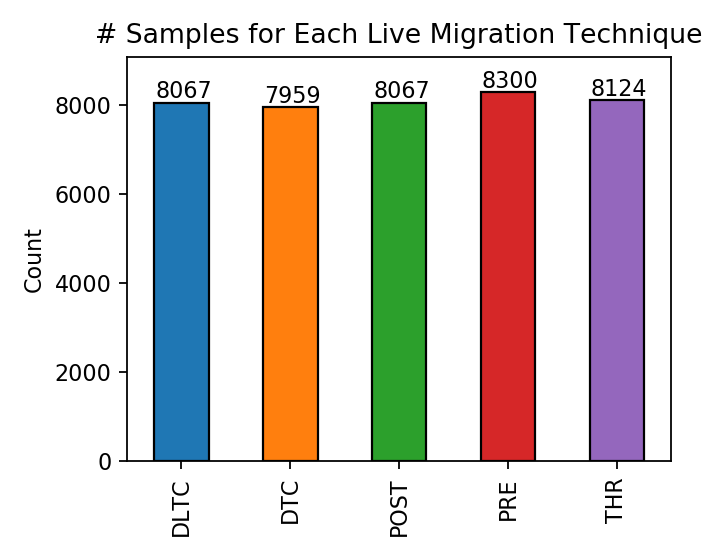

In [3]:
ax = df.groupby('capability')['capability'].count().plot.bar(
    title='# Samples for Each Live Migration Technique', edgecolor='k', linewidth=1.0, width=0.5, figsize=(4.5, 3.5))

ax.set_ylim([0, 9100])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.01, p.get_height() + 100))
    
x_axis = ax.axes.get_xaxis()
x_axis.get_label().set_visible(False)

y_axis = ax.axes.get_yaxis()
y_axis.set_label_text('Count')

plt.tight_layout()

<IPython.core.display.Javascript object>


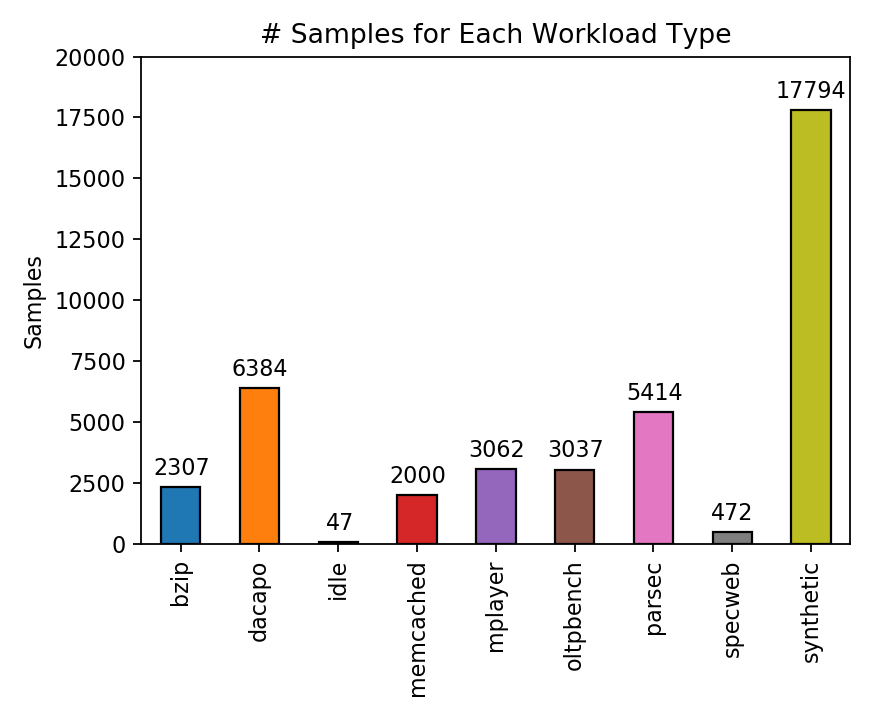

In [4]:
ax = df.groupby('workload_type')['workload_type'].count().plot.bar(
    title='# Samples for Each Workload Type', edgecolor='k', linewidth=1.0, width=0.5, figsize=(5.5, 4.5))

ax.set_ylim([0, 20000])

for p in ax.patches:
    offset = 0
    if p.get_height() < 100:
        offset = 0.1
    elif p.get_height() < 1000:
        offset = -0.02
    elif p.get_height() < 10000:
        offset = -0.1
    elif p.get_height() < 100000:
        offset = -0.2
    ax.annotate(str(p.get_height()), (p.get_x() + offset, p.get_height()+500))
    
x_axis = ax.axes.get_xaxis()
x_axis.get_label().set_visible(False)

y_axis = ax.axes.get_yaxis()
y_axis.set_label_text('Samples')

plt.tight_layout()

## Build Composed Features

We use composed features which are generated from the original features to improve the model accuracy. This step is also called "feature engineering" that is commonly deployed in other machine learning problems.

In [5]:
def get_RPTR(row):
    RPTR = row['VM_wss'] * (row['VM_pdr'] / row['VM_ptr'])**2
    
    if RPTR >= row['VM_wss']:
        RPTR = row['VM_wss']
        
    return RPTR

def get_THR_benefit(row):
    return row['VM_pdr'] * min(row['VM_cpu_util'] / 100, 1.0)

def get_DLTC_benefit(row):
    v = row['VM_mwpp'] / (4096 / 2)
    if v > 1.0:
        v = 1.0 - (v - 1.0)
    return row['VM_wss'] * v

df['RPTR'] = df.apply(lambda row: get_RPTR(row), axis=1)
df['THR_benefit'] = df.apply(lambda row: get_THR_benefit(row), axis=1)
df['DLTC_benefit'] = df.apply(lambda row: get_DLTC_benefit(row), axis=1)
df['VM_nwss'] = df['VM_size'] - df['VM_wss']
df['VM_e_wss'] = df['VM_wss'] * df['VM_wse']
df['VM_e_nwss'] = df['VM_nwss'] * df['VM_nwse']

## Distribution of Feature Values

<IPython.core.display.Javascript object>


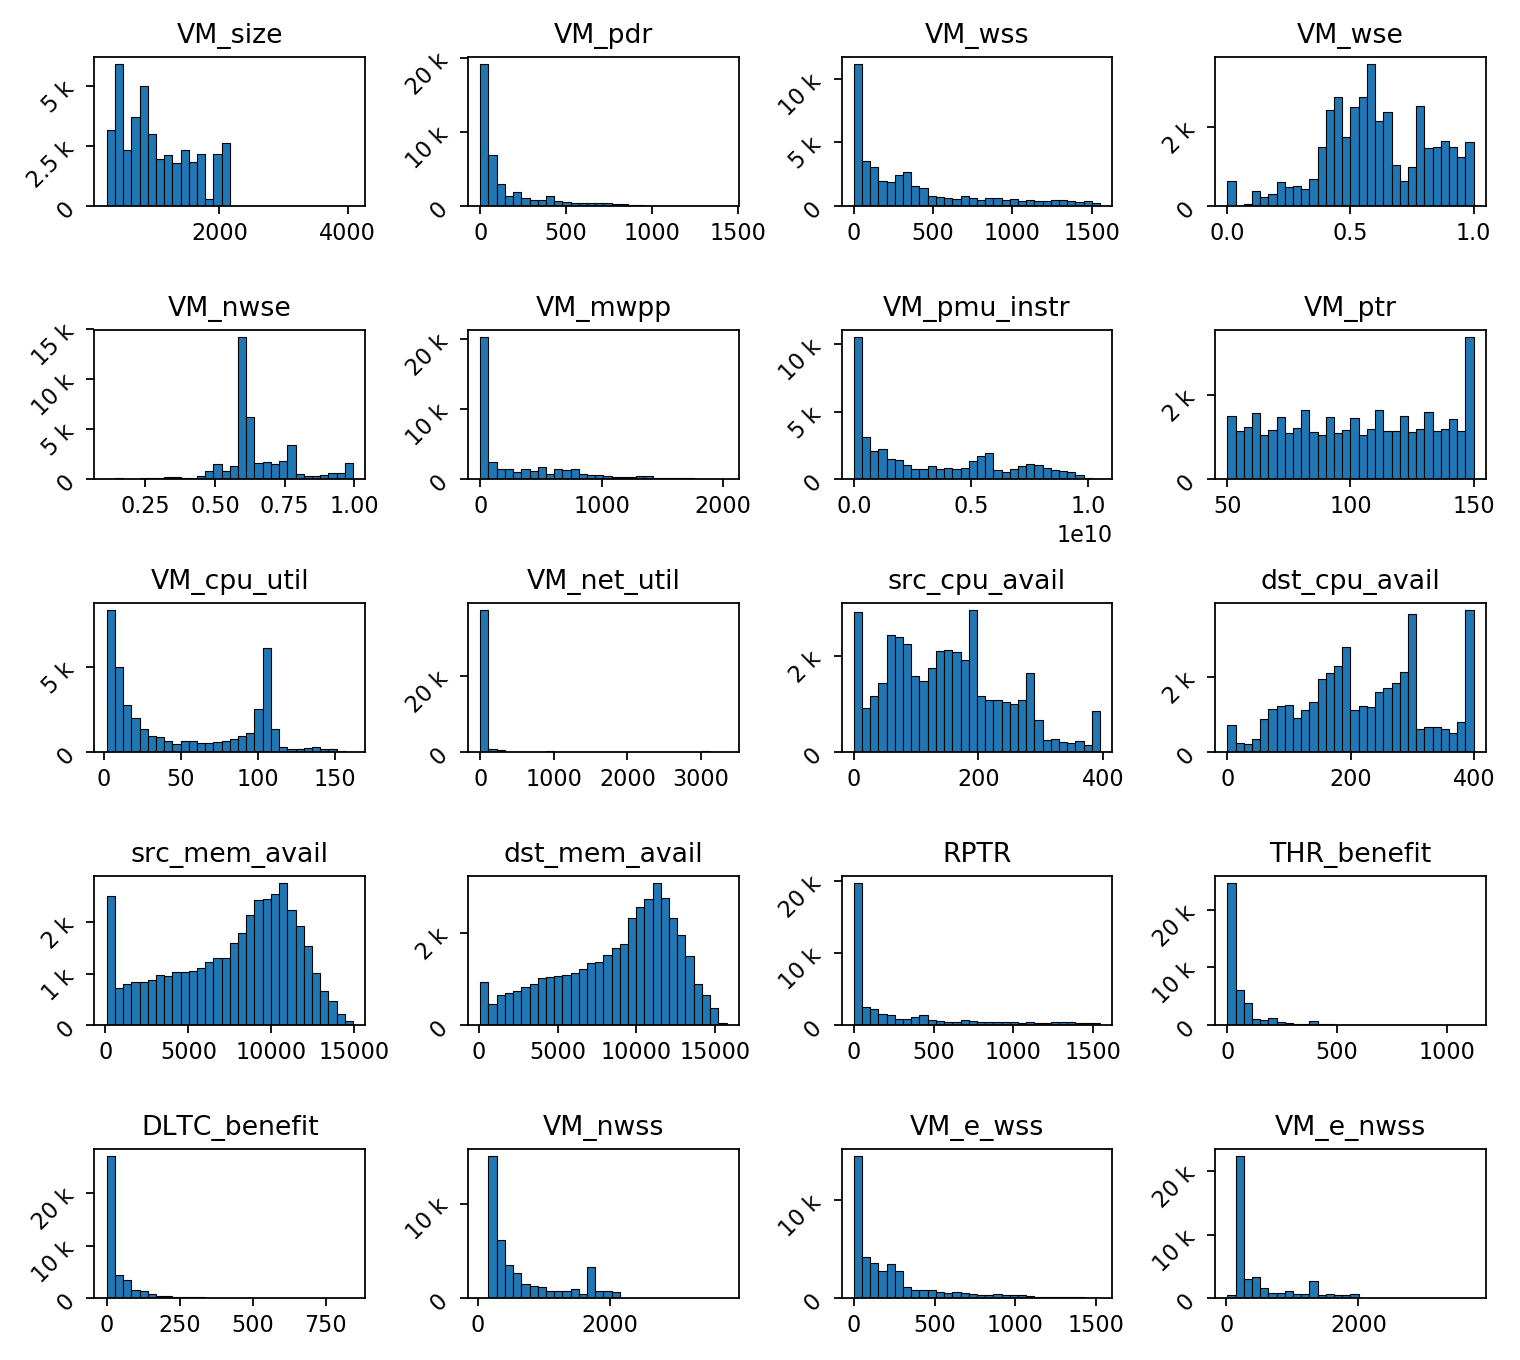

In [6]:
fig, ax_arr = plt.subplots(nrows=5, ncols=4, figsize=(9.5, 8.5))

for i, feature in enumerate(['VM_size', 'VM_pdr', 'VM_wss', 'VM_wse',
                             'VM_nwse', 'VM_mwpp', 'VM_pmu_instr', 'VM_ptr',
                             'VM_cpu_util', 'VM_net_util', 'src_cpu_avail', 'dst_cpu_avail',
                             'src_mem_avail', 'dst_mem_avail', 'RPTR', 'THR_benefit',
                             'DLTC_benefit', 'VM_nwss', 'VM_e_wss', 'VM_e_nwss']):
    row_num, col_num = int(i / 4), i % 4
    df[feature].plot.hist(title=feature, ax=ax_arr[row_num][col_num], edgecolor='black', linewidth=0.5, bins=30)
    
    y_axis = ax_arr[row_num][col_num].axes.get_yaxis()
    formatter = EngFormatter()
    y_axis.set_major_formatter(formatter)
    y_axis.get_label().set_visible(False)
    for tick in ax_arr[row_num][col_num].get_yticklabels():
        tick.set_rotation(45)

plt.tight_layout()

## Distribution of Test Values

<IPython.core.display.Javascript object>


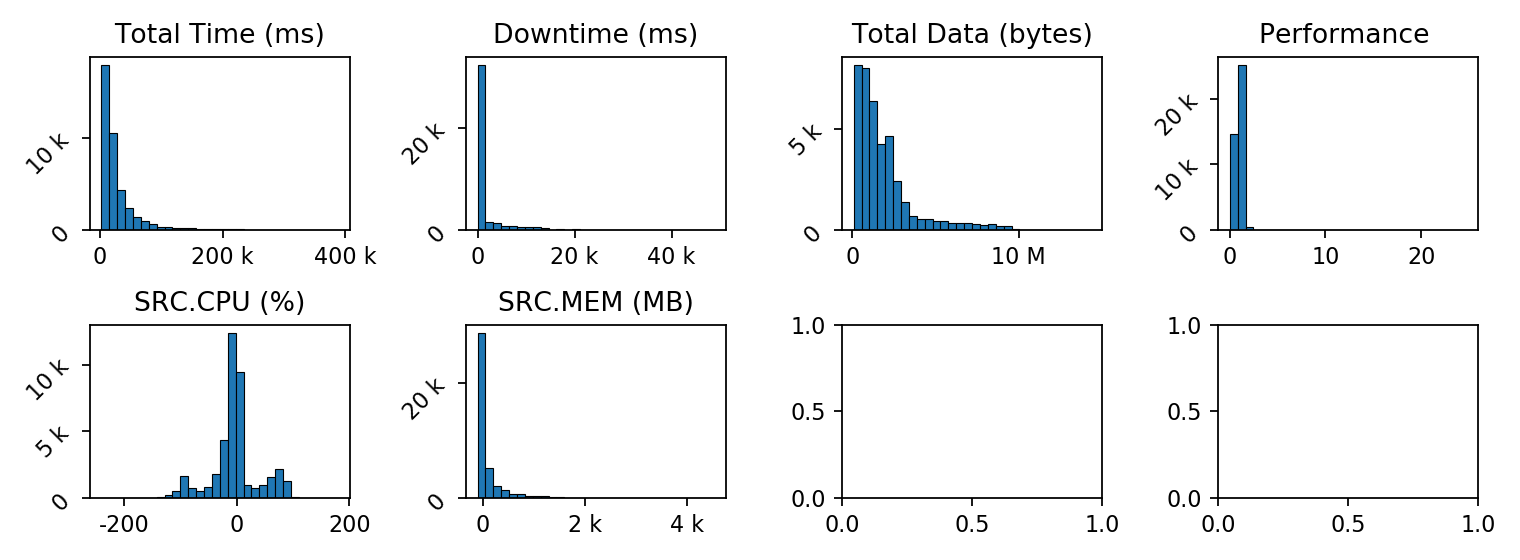

In [152]:
units = {'Total Time': '(ms)', 'Downtime': '(ms)', 'Total Data': '(bytes)', 'Performance': '', 'SRC.CPU': '(%)', 'SRC.MEM': '(MB)'}
fig, ax_arr = plt.subplots(nrows=2, ncols=4, figsize=(9.5, 3.5))

for i, feature in enumerate(['Total Time', 'Downtime', 'Total Data', 'Performance', 'SRC.CPU', 'SRC.MEM']):
    row_num, col_num = int(i / 4), i % 4
    df[feature].plot.hist(title='{} {}'.format(feature, units[feature]),
                          ax=ax_arr[row_num][col_num], edgecolor='black', linewidth=0.5, bins=30)

    x_axis = ax_arr[row_num][col_num].axes.get_xaxis()
    formatter = EngFormatter()
    x_axis.set_major_formatter(formatter)

    y_axis = ax_arr[row_num][col_num].axes.get_yaxis()
    formatter = EngFormatter()
    y_axis.set_major_formatter(formatter)
    y_axis.get_label().set_visible(False)
    for tick in ax_arr[row_num][col_num].get_yticklabels():
        tick.set_rotation(45)

plt.tight_layout()

## Split the Dataset by Different Techniques

We build separate models for each technique and migration metric instead of training one big model. This technique is also called "sub-modeling" which often effectively improves model accuracy by reducing the dimensions of the model.

In [8]:
training_features = ['VM_size', 'VM_pdr', 'VM_wss', 'VM_wse', 'VM_nwse', 'VM_mwpp',
                     'VM_pmu_instr', 'VM_ptr', 'VM_cpu_util', 'VM_net_util',
                     'src_cpu_avail', 'dst_cpu_avail', 'src_mem_avail', 'dst_mem_avail',
                     'RPTR', 'THR_benefit', 'DLTC_benefit', 'VM_nwss', 'VM_e_wss', 'VM_e_nwss']
test_features = ['Total Time', 'Downtime', 'Total Data', 'Performance', 'SRC.CPU', 'SRC.MEM']

dataset = {}

for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
    dataset[technique] = {}
    dataset[technique]['X'] = df[df['capability'] == technique][training_features].copy(deep=True).astype(np.float64)
    dataset[technique]['y'] = df[df['capability'] == technique][test_features].copy(deep=True).astype(np.float64)

## Cross-Validation of the Model

In [48]:
def get_cv_result(X, y, model='linear', n_splits=10):
    cv_result = {'test': [], 'prediction': [], 'training_time': [], 'test_time': []}
    for train, test in KFold(n_splits=n_splits).split(X):
        X_train, y_train = X.iloc[train,:], y.iloc[train,:]
        X_test, y_test = X.iloc[test,:], y.iloc[test,:]
        X_scaler = StandardScaler().fit(X_train)
        y_scaler = StandardScaler().fit(y_train)

        n_jobs = multiprocessing.cpu_count()
        if model == 'linear':
            regr = MultiOutputRegressor(LinearRegression(), n_jobs=n_jobs)
        elif model == 'svr':
            regr = MultiOutputRegressor(SVR(C=10.0), n_jobs=n_jobs)
        
        t1 = time.time()
        regr.fit(X_scaler.transform(X_train), y_scaler.transform(y_train))
        training_time = time.time() - t1
        cv_result['training_time'].append((len(X_train), training_time))
        
        t1 = time.time()
        prediction = regr.predict(X_scaler.transform(X_test))
        prediction = y_scaler.inverse_transform(prediction)
        test_time = time.time() - t1
        cv_result['test_time'].append((len(X_test), test_time))
        
        for row in y_test.values:
            cv_result['test'].append(dict(zip(test_features, row)))
        for row in prediction:
            cv_result['prediction'].append(dict(zip(test_features, row)))

    return cv_result

total_result = {}
for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
    print(technique)
    cv_result = get_cv_result(dataset[technique]['X'], dataset[technique]['y'], model='svr', n_splits=10)
    total_result[technique] = cv_result

PRE
THR
DLTC
DTC
POST


## Compute Absolute Error and Relative Error of the Model

In [74]:
error_result = {}
for technique in total_result:
    n = len(total_result[technique]['test'])
    error_result[technique] = {'abs_err': [], 'rel_err': []}
    for i in range(n):
        test = total_result[technique]['test'][i]
        prediction = total_result[technique]['prediction'][i]
        row_abs_err = {}
        row_rel_err = {}
        to_skip = False
        for metric in test:
            if test[metric] == 0.0:
                continue
            abs_err = abs(prediction[metric] - test[metric])
            rel_err = (prediction[metric] - test[metric]) / test[metric]
            row_abs_err[metric] = abs_err
            row_rel_err[metric] = rel_err
        error_result[technique]['abs_err'].append(row_abs_err)
        error_result[technique]['rel_err'].append(row_rel_err)

## Prediction Accuracy of the Model (Absolute Error)

<IPython.core.display.Javascript object>


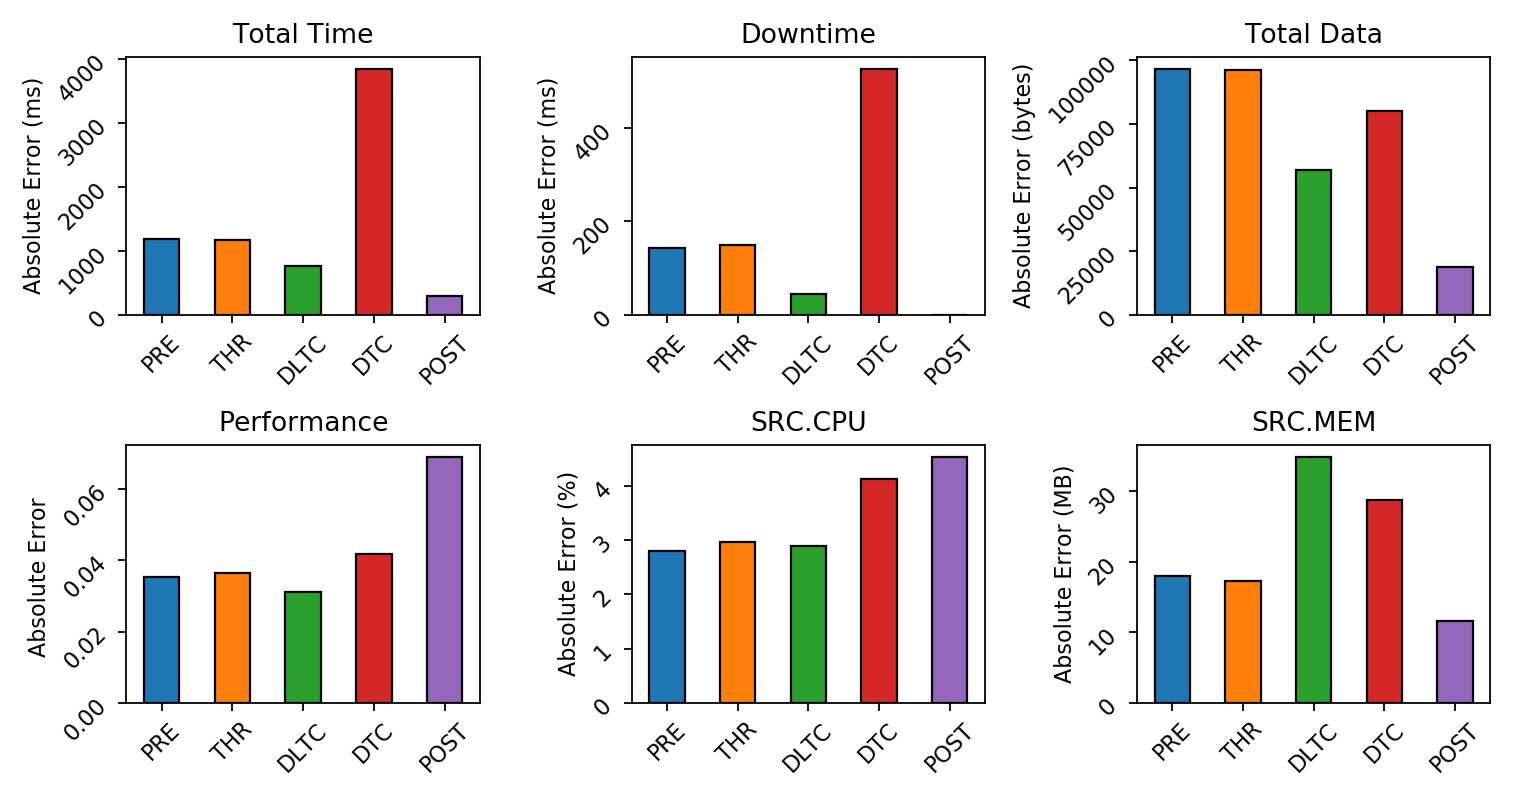

In [348]:
use_geomean = True
df_error = []
for feature in test_features:
    data = {}
    for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
        data[technique] = list(pd.DataFrame(error_result[technique]['abs_err'])[feature].values)
        if use_geomean:
            df_tmp = pd.DataFrame(data[technique], columns=['err']).dropna()
            df_error.append((feature, technique, gmean(abs(df_tmp['err']))))
        else:
            df_error.append((feature, technique, pd.DataFrame(data[technique]).mean().values[0]))
            
df_error = pd.DataFrame(df_error, columns=['Metric', 'Technique', 'Abs.Error'])

units = {'Total Time': '(ms)', 'Downtime': '(ms)', 'Total Data': '(bytes)', 'Performance': '', 'SRC.CPU': '(%)', 'SRC.MEM': '(MB)'}
fig, ax_arr = plt.subplots(nrows=2, ncols=3, figsize=(9.5, 5))
for i, feature in enumerate(test_features):
    row_num, col_num = int(i / 3), i % 3
    df_error[df_error['Metric'] == feature].plot.bar(
        title=feature, x='Technique', y='Abs.Error', edgecolor='k', linewidth=1.0,
        legend=False, ax=ax_arr[row_num][col_num])
    
    x_axis = ax_arr[row_num][col_num].axes.get_xaxis()
    y_axis = ax_arr[row_num][col_num].axes.get_yaxis()
    
    x_axis.get_label().set_visible(False)
    y_axis.set_label_text('{} {}'.format('Absolute Error', units[feature]))
    
    for tick in ax_arr[row_num][col_num].get_xticklabels():
        tick.set_rotation(45)
    for tick in ax_arr[row_num][col_num].get_yticklabels():
        tick.set_rotation(45)
plt.tight_layout()

## Prediction Accuracy of the Model (Relative Error)

<IPython.core.display.Javascript object>


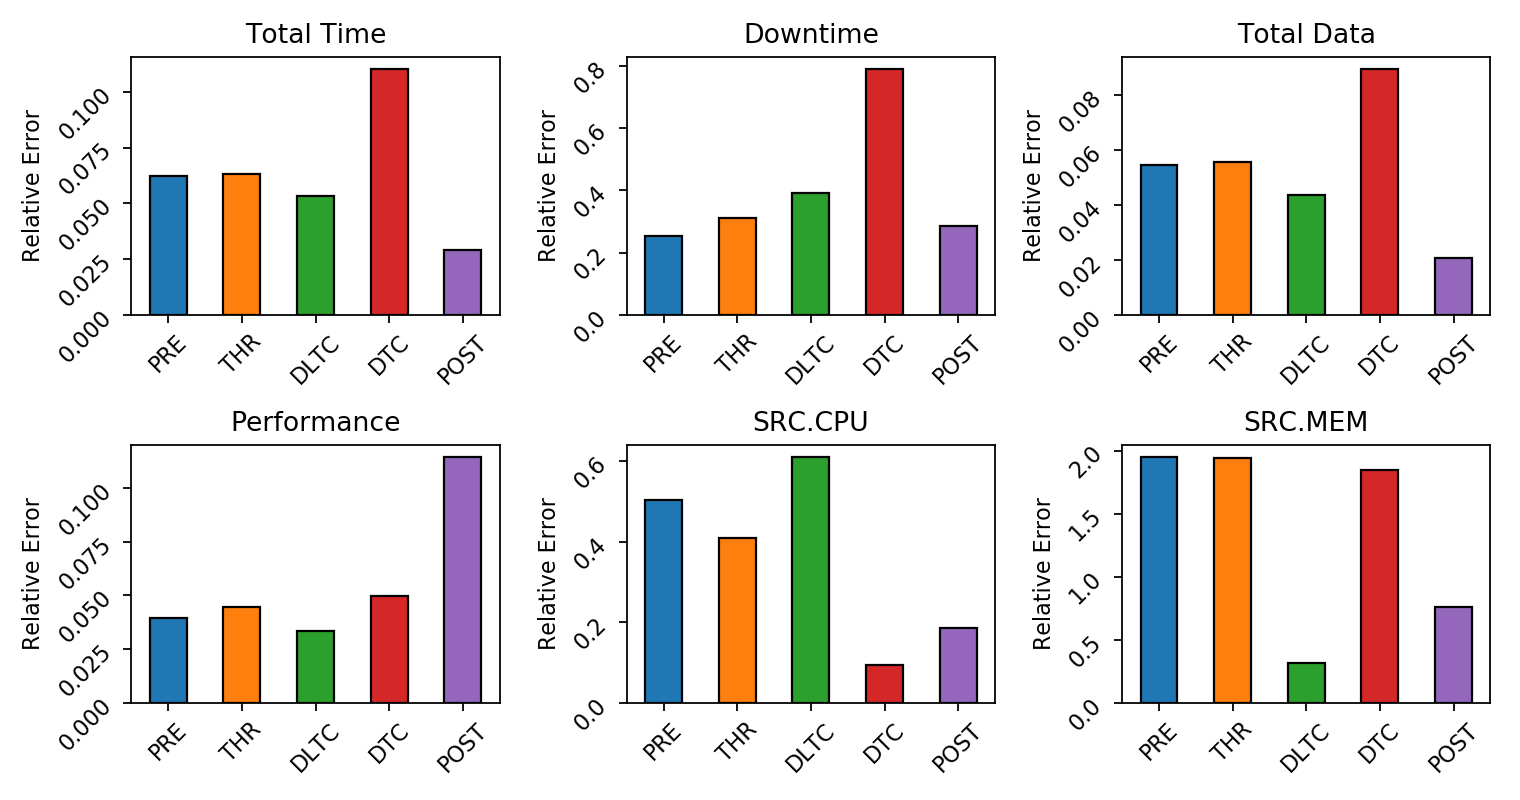

In [233]:
use_geomean = True
df_error = []
for feature in test_features:
    data = {}
    for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
        data[technique] = list(pd.DataFrame(error_result[technique]['rel_err'])[feature].values)
        if use_geomean:
            df_tmp = pd.DataFrame(data[technique], columns=['err']).dropna()
            df_error.append((feature, technique, gmean(abs(df_tmp['err']))))
        else:
            df_error.append((feature, technique, pd.DataFrame(data[technique]).mean().values[0]))

df_error = pd.DataFrame(df_error, columns=['Metric', 'Technique', 'Rel.Error'])

fig, ax_arr = plt.subplots(nrows=2, ncols=3, figsize=(9.5, 5))
for i, feature in enumerate(test_features):
    row_num, col_num = int(i / 3), i % 3
    df_error[df_error['Metric'] == feature].plot.bar(
        title=feature, x='Technique', y='Rel.Error', edgecolor='k', linewidth=1.0,
        legend=False, ax=ax_arr[row_num][col_num])
    
    x_axis = ax_arr[row_num][col_num].axes.get_xaxis()
    y_axis = ax_arr[row_num][col_num].axes.get_yaxis()
    
    x_axis.get_label().set_visible(False)
    y_axis.set_label_text('{}'.format('Relative Error'))
    
    for tick in ax_arr[row_num][col_num].get_xticklabels():
        tick.set_rotation(45)
    for tick in ax_arr[row_num][col_num].get_yticklabels():
        tick.set_rotation(45)
plt.tight_layout()

## Training Time & Prediction Throughput of the Model

In [269]:
for technique in total_result:
    training_time = total_result[technique]['training_time']
    test_time = total_result[technique]['test_time']
    mean_training_time = statistics.mean([v[1] for v in total_result[technique]['training_time']])
    mean_test_time = sum([v[1] for v in total_result[technique]['test_time']])
    test_n = sum([v[0] for v in total_result[technique]['test_time']])
    print('[{:>4s}] Training Time: {:.3f}s, Prediction Throughput: {:.0f} / sec'.format(
        technique, len(test_features) * mean_training_time, test_n / mean_test_time))

[ PRE] Training Time: 46.486s, Prediction Throughput: 4767 / sec
[ THR] Training Time: 48.990s, Prediction Throughput: 5566 / sec
[DLTC] Training Time: 45.416s, Prediction Throughput: 5452 / sec
[ DTC] Training Time: 48.384s, Prediction Throughput: 6088 / sec
[POST] Training Time: 58.364s, Prediction Throughput: 6520 / sec


# Model-guided Live Migration Technique Selection

Let's use the model to solve a real-world problem in datacenter!

## Load the dataset for the technique selection

In [243]:
df = pd.read_csv('dataset/2017.socc.dataset.exclude.512.csv')

# Shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

# Rename column names for readability
df = df.rename(columns={'qemu_tt': 'Total Time', 'qemu_dt': 'Downtime', 'qemu_td': 'Total Data',
                        'performance': 'Performance', 'used_cpu_src': 'SRC.CPU', 'used_mem_src': 'SRC.MEM'})

# Rename the column values to readable strings
df['capability'] = df['capability'].map({0: 'PRE', 1: 'THR', 2: 'DLTC', 3: 'DTC', 4: 'POST'})
df['workload_type'] = df['workload_type'].map({0: 'idle', 1: 'synthetic', 2: 'specweb', 3: 'oltpbench', 4: 'memcached', 5: 'dacapo', 6: 'parsec', 7: 'bzip', 8: 'mplayer'})

df['RPTR'] = df.apply(lambda row: get_RPTR(row), axis=1)
df['THR_benefit'] = df.apply(lambda row: get_THR_benefit(row), axis=1)
df['DLTC_benefit'] = df.apply(lambda row: get_DLTC_benefit(row), axis=1)
df['VM_nwss'] = df['VM_size'] - df['VM_wss']
df['VM_e_wss'] = df['VM_wss'] * df['VM_wse']
df['VM_e_nwss'] = df['VM_nwss'] * df['VM_nwse']

dataset = {}

for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
    dataset[technique] = {}
    dataset[technique]['X'] = df[df['capability'] == technique][training_features].copy(deep=True).astype(np.float64)
    dataset[technique]['y'] = df[df['capability'] == technique][test_features].copy(deep=True).astype(np.float64)

## Model Training

In [300]:
model = 'svr'
regressor = {}
for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']: 
    regressor[technique] = {}
    print('{}'.format(technique))
    regressor[technique] = {}
    X = dataset[technique]['X']
    y = dataset[technique]['y']
    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    n_jobs = multiprocessing.cpu_count()

    if model == 'linear':
        regr = MultiOutputRegressor(LinearRegression(), n_jobs=n_jobs)
    elif model == 'svr':
        regr = MultiOutputRegressor(SVR(C=10.0), n_jobs=n_jobs)

    regr.fit(X_scaler.transform(X), y_scaler.transform(y))
    regressor[technique]['X_scaler'] = X_scaler
    regressor[technique]['y_scaler'] = y_scaler
    regressor[technique]['regr'] = regr

PRE
THR
DLTC
DTC
POST


## Load 512-Migration Data

In [301]:
df_512 = pd.read_csv('dataset/2017.socc.dataset.512.migrations.csv')

# Rename column names for readability
df_512 = df_512.rename(columns={'qemu_tt': 'Total Time', 'qemu_dt': 'Downtime', 'qemu_td': 'Total Data',
                        'performance': 'Performance', 'used_cpu_src': 'SRC.CPU', 'used_mem_src': 'SRC.MEM'})

# Rename the column values to readable strings
df_512['capability'] = df_512['capability'].map({0: 'PRE', 1: 'THR', 2: 'DLTC', 3: 'DTC', 4: 'POST'})

df_512['RPTR'] = df_512.apply(lambda row: get_RPTR(row), axis=1)
df_512['THR_benefit'] = df_512.apply(lambda row: get_THR_benefit(row), axis=1)
df_512['DLTC_benefit'] = df_512.apply(lambda row: get_DLTC_benefit(row), axis=1)
df_512['VM_nwss'] = df_512['VM_size'] - df_512['VM_wss']
df_512['VM_e_wss'] = df_512['VM_wss'] * df_512['VM_wse']
df_512['VM_e_nwss'] = df_512['VM_nwss'] * df_512['VM_nwse']

df_512[:10]

workload_seed capability workload_type      VM_size      VM_pdr  \
0              0        PRE           mem  1541.756510   84.799959   
1              0        THR           mem  1538.423177   84.636787   
2              0       DLTC           mem  1540.402344   85.114361   
3              0        DTC           mem  1542.410156   84.529605   
4              0       POST           mem  1541.221540   84.767838   
5              1        PRE           mem  1391.880208  759.063939   
6              1        THR           mem  1389.763021  761.982593   
7              1       DLTC           mem  1389.847656  759.544476   
8              1        DTC           mem  1391.243490  755.559485   
9              1       POST           mem  1391.274740  758.956689   

        VM_wss    VM_wse   VM_nwse     VM_mwpp  VM_pmu_instr     ...      \
0  1295.003906  0.506548  0.597018  440.932258  4.517526e+09     ...       
1  1295.356771  0.507007  0.595175  442.644380  4.526916e+09     ...       
2  1297.440430  0.507299  0.599785  441.616667  4.525744e+09     ...       
3  1294.928385  0.506584  0.595487  444.262631  4.527548e+09     ...       
4  1296.336682  0.507088  0.598782  442.822673  4.533781e+09     ...       
5  1143.683594  0.831478  0.594690   11.548263  6.464453e+08     ...       
6  1143.772135  0.831511  0.597532   11.552912  6.476263e+08     ...       
7  1144.244792  0.831506  0.598306   11.545806  6.479997e+08     ...       
8  1144.138021  0.831389  0.597088   11.551970  6.449203e+08     ...       
9  1144.283854  0.831397  0.595453   11.557376  6.447838e+08     ...       

     Total Data  Performance    SRC.CPU      SRC.MEM         RPTR  \
0  8.166059e+06     0.878682  -9.986193    -4.553385  1295.003906   
1  5.474302e+06     0.691450 -26.230435    -2.264323  1295.356771   
2  7.541864e+06     0.826448   3.416986  1281.187500  1297.440430   
3  4.594477e+06     0.585142  31.905145   -44.541667  1294.928385   
4  1.586088e+06     0.519915 -80.687340   -34.598958  1296.336682   
5  7.186149e+06     0.802118  -0.494390     1.003906  1143.683594   
6  7.176097e+06     0.681157  -4.233842    -3.734375  1143.772135   
7  2.646564e+06     0.958486   0.260787  1122.799479  1144.244792   
8  6.078336e+06     0.937337  83.571420   -21.092448  1144.138021   
9  1.432590e+06     0.227810 -15.225159   -38.576823  1144.283854   

   THR_benefit  DLTC_benefit     VM_nwss    VM_e_wss   VM_e_nwss  
0    59.695133    278.812987  246.752604  655.981639  147.315828  
1    59.725360    279.971872  243.066406  656.754950  144.667129  
2    62.322964    279.771152  242.961914  658.190557  145.724851  
3    59.480666    280.902486  247.481771  655.989570  147.372260  
4    59.681748    280.296521  244.884859  657.356960  146.632599  
5   193.573353      6.449004  248.196615  950.947747  147.600045  
6   199.893434      6.452099  245.990885  951.058731  146.987344  
7   194.708624      6.450795  245.602865  951.446791  146.945586  
8   186.299382      6.453637  247.105469  951.224146  147.543628  
9   201.231945      6.457480  246.990885  951.354164  147.071464  

[10 rows x 29 columns]

## Prepare the ML Model and Oracle

In [ ]:
predict_model = {}
for seed, row in df_512.groupby(['workload_seed']).mean().iterrows():
    predict_model[seed] = {}
    X = [row[f] for f in training_features]
    for technique in ['PRE', 'THR', 'DLTC', 'DTC', 'POST']:
        predict_model[seed][technique] = {}
        regr = regressor[technique]['regr']
        X_scaler = regressor[technique]['X_scaler']
        y_scaler = regressor[technique]['y_scaler']
        X_scaled = X_scaler.transform(np.array(X).reshape(1, -1))
        y_prediction = y_scaler.inverse_transform(regr.predict(X_scaled))[0]
        y_prediction = dict(zip(test_features, y_prediction))
        predict_model[seed][technique].update(y_prediction)

predict_oracle = {}
for _, row in df_512.iterrows():
    seed = row['workload_seed']
    technique = row['capability']
    if seed not in predict_oracle:
        predict_oracle[seed] = {}
    if technique not in predict_oracle[seed]:
        predict_oracle[seed][technique] = {}
    predict_oracle[seed][technique].update(dict(zip(test_features, [row[metric] for metric in test_features])))


print('One Case Test')
print(' [MODEL] Seed: {}, Technique: {}, Total Time: {}'.format(0, 'PRE', predict_model[0]['PRE']['Total Time']))
print('[ORACLE] Seed: {}, Technique: {}, Total Time: {}'.format(0, 'PRE', predict_oracle[0]['PRE']['Total Time']))

## Minimize Total Migration with Model-guided Live Migration Technique Selection

The ML Model-guided live migration technique selection shows comparable result against using Oracle.

### Using ML Model

In [371]:
selection = {}
total_time_sum = 0
for i in range(len(predict_model)):
    total_time, technique = (sorted([(predict_model[i][technique]['Total Time'], technique) for technique in predict_model[i]])[0])
    if technique not in selection:
        selection[technique] = 1
    else:
        selection[technique] += 1
    total_time_sum += predict_oracle[i][technique]['Total Time']
print('Selected Techniques: {}'.format(selection))
print('Mean Total Migration Time: {:.0f} ms'.format(total_time_sum / len(predict_model)))

Selected Techniques: {'POST': 441, 'THR': 30, 'DLTC': 16, 'DTC': 6, 'PRE': 19}
Mean Total Migration Time: 12786 ms


### Using Oracle

In [372]:
selection = {}
total_time_sum = 0
for i in range(len(predict_oracle)):
    total_time, technique = (sorted([(predict_oracle[i][technique]['Total Time'], technique) for technique in predict_oracle[i]])[0])
    if technique not in selection:
        selection[technique] = 1
    else:
        selection[technique] += 1
    total_time_sum += total_time
print('Selected Techniques: {}'.format(selection))
print('Mean Total Migration Time: {:.0f} ms'.format(total_time_sum / len(predict_model)))

Selected Techniques: {'POST': 504, 'THR': 1, 'PRE': 3, 'DTC': 3, 'DLTC': 1}
Mean Total Migration Time: 12533 ms
